# Multivariate Regression RainBarrel, MorrisIT, and WakefieldRG

# Show the collections that have been generated

In [2]:
from pymongo import MongoClient
from process_collection import *
#  IMPORTANT:  Set these for each run:
#################################################
# mongoServer = None   # use the local mongodb server installed on your computer
#mongoServer = 'mongodb://server.mcgarity.info:27017/'  # Art's personal server
#mongoServer = 'mongodb://ubuntu:27017/'  # ubuntu Linux virtual machine on Art's Mac
mongoServer = 'mongodb://aws-2.greenphilly.net:27017/'  # aws-2 server for GreenPhilly
database = "jcohen4"
username = "jcohen4"
password = "wingohocking"
authenticationDatabase = "jcohen4"

client = MongoClient(mongoServer)
################################################

db = client[database]
db.authenticate(username, password, source=authenticationDatabase)  # pass credentials to database
collectionNames = sorted(db.collection_names())
collectionNames

[u'2008',
 u'2008trial1',
 u'2008trial3',
 u'2008trial4',
 u'2008trial6',
 u'first_wingo_test',
 u'fourth_wingo_test',
 u'impervFixed',
 u'impervNotFixed',
 u'july',
 u'july10',
 u'july12',
 u'july13',
 u'july14',
 u'july15',
 u'july16',
 u'july17',
 u'july2',
 u'july21',
 u'july22',
 u'july23',
 u'july24',
 u'july3',
 u'july4',
 u'july5',
 u'july6',
 u'july7',
 u'july8',
 u'july9',
 u'largeTrialLinier',
 u'multivariate_250_2010',
 u'multivariate_random_250_2010',
 u'multivariate_random_250_2011',
 u'multivariate_random_250_2012',
 u'multivariate_random_250_2013',
 u'randomTrial1',
 u'randomTrial2',
 u'randomTrial4',
 u'randomTrial5',
 u'random_multivariate',
 u'random_multivariate2',
 u'random_multivariate2009',
 u'random_multivariate2009year',
 u'random_multivariate2010',
 u'random_multivariate2012year',
 u'random_multivariate250',
 u'random_multivariate250_2009',
 u'random_multivariate3',
 u'random_multivariate5',
 u'random_multivariate6',
 u'random_multivariate7',
 u'random_multiva

In [3]:
from get_cso import calculate_cso
acft_to_mgal = 0.325851  # 1 acre-ft = 0.325851 MGal
collectionName = 'y17m01d12_AEM_45_Subcat_RainBarrel_MorrisIT_WakefieldRG_1'
runs = db[collectionName]
cursor = runs.find()
noLidRun = cursor[0]
noLidVolume = noLidRun['volume']  # 10^6 Gal / yr
noLidPeak = noLidRun['peak']   # cfs
noLidRunoff = noLidRun['runoff']  # acre-ft/yr
outflowSeries = noLidRun['outflow_series']
ratio = 0.05
csoResults = calculate_cso(outflowSeries,ratio)
csoVolumeMGal = csoResults['cso_volume']/1e6
print "noLidPeak = %0.2f cfs, noLidVolume = %0.2f MGal" % (noLidPeak,noLidVolume)
print "noLid Runoff = %0.2f acre-ft = %0.2f MGal" % (noLidRunoff,noLidRunoff*acft_to_mgal)
print "noLid csoVolumeMGal = %0.2f MGal" % csoVolumeMGal
# NOTE: Volume is total flow volume at sewer outlet while Runoff is total runoff volume
#       so they will likely be slightly different
noLidRunParamsList = noLidRun['runParamList']
#print noLidRunParamsList

noLidPeak = 1948.45 cfs, noLidVolume = 1948.90 MGal
noLid Runoff = 5987.73 acre-ft = 1951.11 MGal
noLid csoVolumeMGal = 687.45 MGal


In [13]:
# Read data for all runs from the mongodb database
from process_collection import * 
numSubcatch = 45
numLID = 3
numVariables = numSubcatch*numLID
collectionName = 'y17m01d12_AEM_45_Subcat_RainBarrel_MorrisIT_WakefieldRG_1'
results = volume_reduction_and_runoff_volume_vs_lid_number(collectionName, numVariables, db)
originalVolReduction = results["volReductionList"]
originalNumberOfRuns = len(originalVolReduction)
originalLidNumbers = results['numLists']  # first index contains LID numbers for all runs for each variable
originalLidTransposed = zip(*originalLidNumbers)  # now first index contains LID numbers for all variables for each run
print "Number of Runs stored in Database = %d" % originalNumberOfRuns

Number of Runs stored in Database = 2043


In [14]:
# Compute Annual CSO Flows from results stored on Mongo
from get_cso import * 
ratio = 0.05
# ALERT:  in cso_reduction, collectionName and numSubCatch is never used !!!
originalCsoResults = cso_reduction(collectionName, ratio, numSubcatch, results) 
originalCsoReduction = originalCsoResults["csoReduction"]
originalCsoVolume = originalCsoResults["cso"]
originalTotVol = originalCsoResults["totalVol"]

print originalVolReduction[0]
print originalCsoReduction[0]
print originalTotVol[0]
print originalCsoVolume[0]
print originalLidTransposed[0]

0.0
0.0
1949310793.28
687453499.127
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


In [21]:
# Filter out runs having more than 1600 rain barrel greened acres to avoid decreasing CSO reductions
gaPerLidRainBarrel = 0.1
maxRainBarrelGA = 1600.0
lidTransposed = []
volReduction = []
csoReduction = []
totVol = []
csoVolume = []
for run in range(0,originalNumberOfRuns):
    lidList = originalLidTransposed[run]
    gaTotalRainBarrelsThisRun = 0.0
    # Rainbarrels are the first numSubcatch (45) LID in each run
    for subcat in range(0,numSubcatch):
        numberRainBarrels = lidList[subcat]
        thisGreenedAcres = gaPerLidRainBarrel*numberRainBarrels   
        gaTotalRainBarrelsThisRun += thisGreenedAcres
    if gaTotalRainBarrelsThisRun <= maxRainBarrelGA:
        lidTransposed.append(lidList)
        volReduction.append(originalVolReduction[run])
        csoReduction.append(originalCsoReduction[run])
        totVol.append(originalTotVol[run])
        csoVolume.append(originalCsoVolume[run])
volReductionMgal = [x / 1e6 for x in volReduction]
csoReductionMgal = [x / 1e6 for x in csoReduction] 
numberOfRuns = len(volReduction)
print "Filtered Number of Runs stored in Database = %d" % numberOfRuns

Filtered Number of Runs stored in Database = 1982


In [22]:
# Compute total greened acres for each run and greened acres by LID for each run
%matplotlib inline
import matplotlib.pyplot as plt
gaPerLid = [0.1,0.936,0.747]
greenedAcres = []
lidGreenedAcresDict = {}
for lid in range(0,numLID):
    lidGreenedAcresDict[lid] = []

for run in range(0,numberOfRuns):
    variable = 0
    lidList = lidTransposed[run]
    gaTotalThisRun = 0.0
    for lid in range(0,numLID):
        gaTotalThisLID = 0.0
        for subcat in range(0,numSubcatch):
            numberLID = lidList[variable]
            thisGreenedAcres = gaPerLid[lid]*numberLID
            gaTotalThisRun += thisGreenedAcres
            gaTotalThisLID += thisGreenedAcres
            variable += 1
        lidGreenedAcresDict[lid].append(gaTotalThisLID)
    greenedAcres.append(gaTotalThisRun)
#print greenedAcres
print lidGreenedAcresDict[0][0]
#print csoReduction
#print [greenedAcres]

0.0


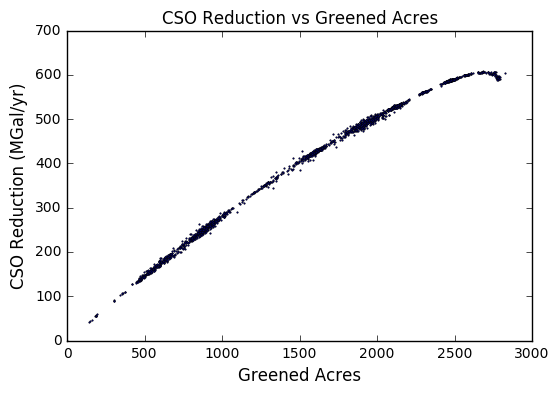

In [23]:
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction vs Greened Acres")
ax1.plot(greenedAcres,csoReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal/yr)",fontsize=12)

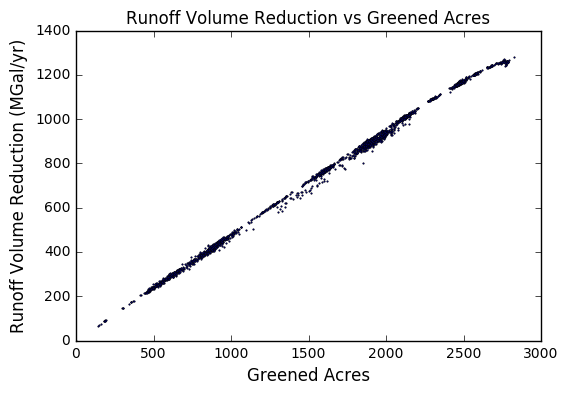

In [24]:
(fig, ax1) = plt.subplots()
plt.title("Runoff Volume Reduction vs Greened Acres")
ax1.plot(greenedAcres,volReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("Runoff Volume Reduction (MGal/yr)",fontsize=12)

Total number of SWMM runs = 1982


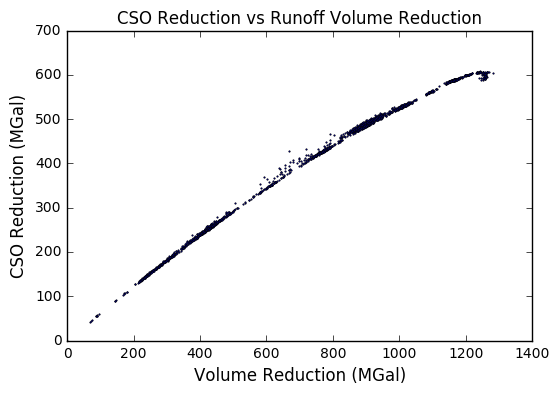

In [25]:
# SCATTER PLOT OF CSO ANNUAL VOLUME REDUCTION VS SEWER OUTFLOW ANNUAL VOLUME REDUCTION
%matplotlib inline
import matplotlib.pyplot as plt
print "Total number of SWMM runs = %d" % len(volReductionMgal)
#xRange = [50,70]
#yRange = [25,45]
(fig, ax1) = plt.subplots()
ax1.plot(volReductionMgal,csoReductionMgal,'ko',color = 'b',markersize = 1)
plt.title("CSO Reduction vs Runoff Volume Reduction")
ax1.set_xlabel("Volume Reduction (MGal)",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal)",fontsize=12)
#plt.xlim(xRange)
#plt.ylim(yRange)

0.0
Exact r-squared:
0.996319320854
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.662e+05
Date:                Sun, 15 Jan 2017   Prob (F-statistic):               0.00
Time:                        19:26:06   Log-Likelihood:                -23394.
No. Observations:                1355   AIC:                         4.679e+04
Df Residuals:                    1353   BIC:                         4.680e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.37

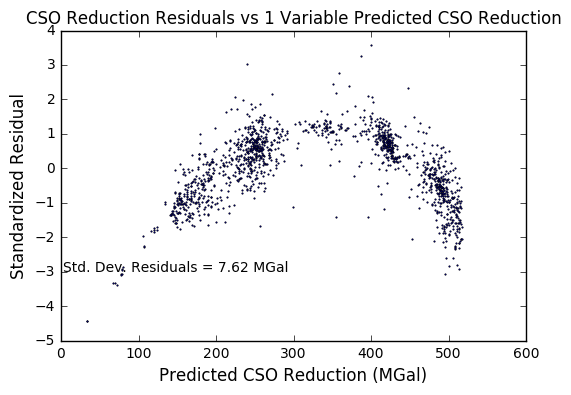

In [31]:
#Single Variable Regression for LIMITED GA CSO reductions for each run vs total greened acres (combining LIDs) for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

import numpy as np
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt

def regress(yList,xList):   
    # y = list containing dependent variable values 
    # x = list of lists: each list contains values for all independent variables for each data point
    X = sm.add_constant(xList)
    results = sm.OLS(yList,X).fit()
    return results


upperGreenedAcreLimit = 2000.0  # Upper limit on greened acres for the regresions below 
limitedGreenedAcres = []
limitedCsoReduction = []
for run in range(0,numberOfRuns):
    if greenedAcres[run] <= upperGreenedAcreLimit:
        limitedGreenedAcres.append([greenedAcres[run]])
        limitedCsoReduction.append(csoReduction[run])
print limitedGreenedAcres[0][0]
csoReductionVsTotalGreenedAcresStats = regress(limitedCsoReduction,limitedGreenedAcres)
print "Exact r-squared:"
print csoReductionVsTotalGreenedAcresStats.rsquared
print csoReductionVsTotalGreenedAcresStats.summary()
print csoReductionVsTotalGreenedAcresStats.params

# Generate Residuals Plot for LIMITED GA CSO reductions for each run vs total greened acres (combining LIDs) for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

X = sm.add_constant(limitedGreenedAcres)
yPredicted = np.dot(X,csoReductionVsTotalGreenedAcresStats.params)
residuals = limitedCsoReduction - yPredicted
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]

yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResidualsMGal = stdDevResiduals/1e6

(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs 1 Variable Predicted CSO Reduction")
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResidualsMGal
ax1.text(2,-3,stdDevText)

Exact r-squared:
0.996488977549
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.278e+05
Date:                Sun, 15 Jan 2017   Prob (F-statistic):               0.00
Time:                        19:26:31   Log-Likelihood:                -23362.
No. Observations:                1355   AIC:                         4.673e+04
Df Residuals:                    1351   BIC:                         4.675e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.491e+0

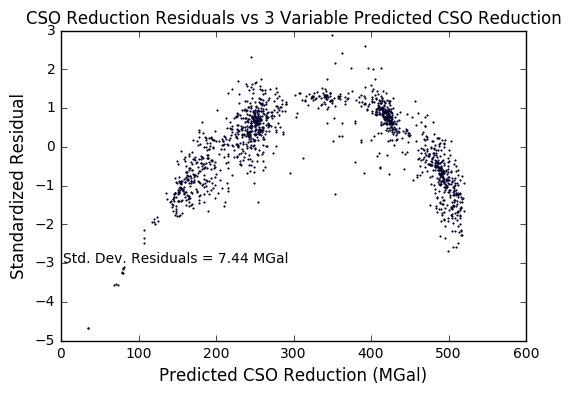

In [32]:
#THREE Variable Regression for LIMITED GA CSO reductions for each run vs greened acres BY LID for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

import numpy as np
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt

def regress(yList,xList):   
    # y = list containing dependent variable values 
    # x = list of lists: each list contains values for all independent variables for each data point
    X = sm.add_constant(xList)
    results = sm.OLS(yList,X).fit()
    return results

limitedCsoReduction = []
limitedLidGreenedAcres = []
#print lidGreenedAcresDict[0]
for run in range(0,numberOfRuns):
    if greenedAcres[run] <= upperGreenedAcreLimit:
        limitedCsoReduction.append(csoReduction[run])
        #print lidGreenedAcres[0][run]
        independentVariableList = [lidGreenedAcresDict[0][run], lidGreenedAcresDict[1][run], lidGreenedAcresDict[2][run]]
        limitedLidGreenedAcres.append(independentVariableList)
csoReductionVsLIDGreenedAcresStats = regress(limitedCsoReduction,limitedLidGreenedAcres)
print "Exact r-squared:"
print csoReductionVsLIDGreenedAcresStats.rsquared
print csoReductionVsLIDGreenedAcresStats.summary()
print csoReductionVsLIDGreenedAcresStats.params

# Generate Residuals Plot for LIMITED GA CSO reductions for each run vs greened acres BY LID for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

X = sm.add_constant(limitedLidGreenedAcres)
yPredicted = np.dot(X,csoReductionVsLIDGreenedAcresStats.params)
residuals = limitedCsoReduction - yPredicted
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]

yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResidualsMGal = stdDevResiduals/1e6

#print standardizedResiduals
#print yPredictedMGal
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs 3 Variable Predicted CSO Reduction")
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResidualsMGal
ax1.text(2,-3,stdDevText)

Exact r-squared:
0.862279996643
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     114.0
Date:                Sun, 15 Jan 2017   Prob (F-statistic):          1.41e-234
Time:                        19:22:04   Log-Likelihood:                -11541.
No. Observations:                 635   AIC:                         2.315e+04
Df Residuals:                     601   BIC:                         2.330e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       4.174e+0

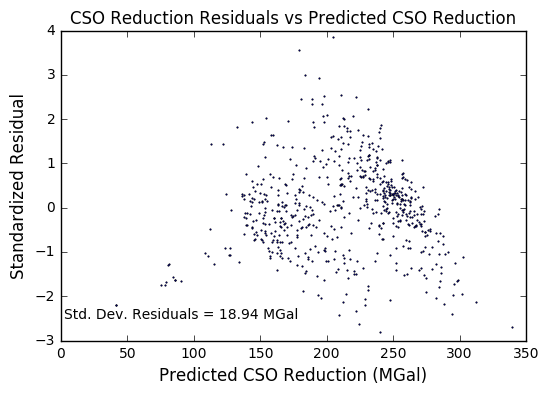

In [28]:
# Multivariable Regression for LIMITED GA runs for Annual CSO Volumes vs FILTERED subcatchments
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range
import numpy as np
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt

def regress(yList,xList):   
    # y = list containing dependent variable values 
    # x = list of lists: each list contains values for all independent variables for each data point
    X = sm.add_constant(xList)
    results = sm.OLS(yList,X).fit()
    return results

numberOfSubcatchmentsFiltered = 11
gaPerLid = [0.1,0.936,0.747]
greenedAcresFiltered = []
csoReductionFiltered = []
runoffVolumeReductionFiltered = []   # for runoff volume regression in later block
#chunks = [data[x:x+100] for x in xrange(0, len(data), 100)]
for run in range(0,numberOfRuns):
    if greenedAcres[run] <= upperGreenedAcreLimit:
        csoReductionFiltered.append(csoReduction[run])
        runoffVolumeReductionFiltered.append(volReduction[run])
        lidList = lidTransposed[run]
        lidChunks = [lidList[x:x+numSubcatch] for x in range(0,len(lidList),numSubcatch)]
        #print len(lidChunks[0])
        filteredSubcatsVariables = []
        for lid in range(0,numLID):
            filteredSubcats = lidChunks[lid][0:numberOfSubcatchmentsFiltered]
            filteredSubcatsGreenedAcres = [gaPerLid[lid]*filteredSubcats[i] for i in range(0,len(filteredSubcats))]
            filteredSubcatsVariables += filteredSubcatsGreenedAcres
        greenedAcresFiltered.append(filteredSubcatsVariables)

csoReductionStats = regress(csoReductionFiltered,greenedAcresFiltered)
print "Exact r-squared:"
print csoReductionStats.rsquared
print csoReductionStats.summary()
#print csoReductionStats.params

# Generate Residuals Plot for for LIMITED GA runs for Annual CSO Volumes vs FILTERED subcatchments
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

X = sm.add_constant(greenedAcresFiltered)
#print X
yPredicted = np.dot(X,csoReductionStats.params)
residuals = csoReductionFiltered - yPredicted
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]

yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResidualsMGal = stdDevResiduals/1e6

(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs Predicted CSO Reduction")
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResidualsMGal
ax1.text(2,-2.5,stdDevText)

     

Exact r-squared:
0.865647377074
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     117.3
Date:                Sun, 15 Jan 2017   Prob (F-statistic):          8.78e-238
Time:                        19:22:04   Log-Likelihood:                -11882.
No. Observations:                 635   AIC:                         2.383e+04
Df Residuals:                     601   BIC:                         2.398e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       5.774e+0

NameError: name 'stdDevResidualsMgal' is not defined

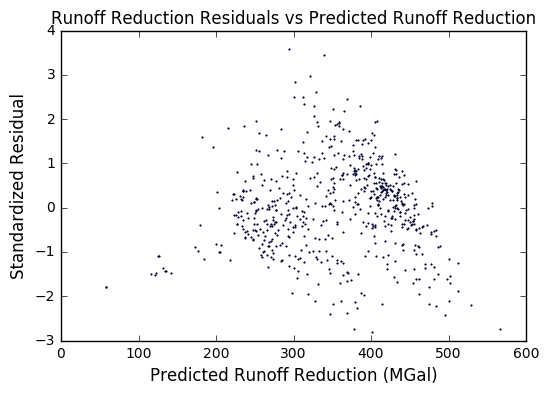

In [29]:
# Multivariable Regression for Annual Runoff VOLUME Reductions vs Filtered PWD Wingohocking subcatchments
import numpy as np
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics


def regress(yList,xList):   
    # y = list containing dependent variable values 
    # x = list of lists: each list contains values for all independent variables for each data point
    X = sm.add_constant(xList)
    results = sm.OLS(yList,X).fit()
    return results


runoffReductionStats = regress(runoffVolumeReductionFiltered,greenedAcresFiltered)
print "Exact r-squared:"
print runoffReductionStats.rsquared
print runoffReductionStats.summary()
#print runoffReductionStats.params

# Generate Residuals Plot for FILTERED Annual RUNOFF Volumes vs reduced number of subcatchments

X = sm.add_constant(greenedAcresFiltered)
#print X
yPredicted = np.dot(X,runoffReductionStats.params)
residuals = runoffVolumeReductionFiltered - yPredicted
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]

yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResidualsMGal = stdDevResiduals/1e6


(fig, ax1) = plt.subplots()
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
plt.title("Runoff Reduction Residuals vs Predicted Runoff Reduction")
ax1.set_xlabel("Predicted Runoff Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResidualsMgal
ax1.text(2,-2.5,stdDevText)

In [ ]:
# Multivariable regression for statmodel cso reduction parameters versus subcatchment properties
import yaml
from swmm_objects import *
from swmm_read_cso_time_series import *
%matplotlib inline
import matplotlib.pyplot as plt

def regress(yList,xList):   
    # y = list containing dependent variable values 
    # x = list of lists: each list contains values for all independent variables for each data point
    X = sm.add_constant(xList)
    results = sm.OLS(yList,X).fit()
    return results

swmmInpFile = "wingohocking_PWD.inp"  # initial SWMM .inp file
lidListFile = "PWD_wingo_RainBarrel_MorrisIT_WakefieldRG_LID_List.yaml"
infile = open(swmmInpFile,'r')
swmmInpStr = infile.readlines()
infile.close()
(section_names,sections) = read_inp(swmmInpStr)
model = swmm_model("Model",section_names,sections)
f = open(lidListFile,'r')   # Read the LID parameters used to calculate [LID_USAGE]
lidUsageList = yaml.load(f)  # list of dicts, one for each line in [LID_USAGE]
f.close()
lidUsageChunks = [lidUsageList[x:x+numSubcatch] for x in range(0,len(lidUsageList),numSubcatch)]
#print lidUsageChunks[1]

# These lists will hold LID and subcatchment parameters for the filtered subcatchments only
lidGreenedAcresList = []
lidContribImpervArea = []
subcatArea = []
subcatPctImperv = []
subcatImpervArea = []
subcatWidth = []
subcatSlope = []

for lid in range(0,numLID):
    listItem = 1
    for lidUsage in lidUsageChunks[lid]:
        if listItem <= numberOfSubcatchmentsFiltered:   # limit the lists to filtered subcatchments
            subcatName = lidUsage['Subcat']
            lidGreenedAcresList.append(lidUsage['GreenedAcres'])
            lidContribImpervArea.append(lidUsage['ContribImpervArea'])
            thisSubcatArea = model.getSubcatchmentArea(subcatName)
            subcatArea.append(thisSubcatArea)
            thisSubcatPctImperv = model.getSubcatchmentPctImperv(subcatName)
            subcatPctImperv.append(thisSubcatPctImperv)
            thisSubcatImpervArea = (thisSubcatPctImperv/100.0)*thisSubcatArea
            subcatImpervArea.append(thisSubcatImpervArea)
            subcatWidth.append(model.getSubcatchmentWidth(subcatName))
            subcatSlope.append(model.getSubcatchmentSlope(subcatName))
            listItem += 1
        else:
            break   # ignore subcatchments indexed above the filtered group

#paramIndVars = [lidGreenedAcresList,lidContribImpervArea,subcatArea]  # choose which independent vars to use
paramIndVars = [subcatArea,subcatPctImperv,subcatWidth,subcatSlope]
#paramIndVars = [subcatArea]
#paramIndVars = [subcatPctImperv]
#paramIndVars = [lidGreenedAcresList,]
#paramIndVars = [lidContribImpervArea,subcatArea]
#paramIndVars = [subcatImpervArea]
#paramIndVars = [subcatSlope]
numberOfParamIndVars = len(paramIndVars)
#numberOfParamDependentVarValues = len(csoReductionStats.params)-1  
paramDepVarValues = csoReductionStats.params[1:len(csoReductionStats.params)] # only lid/subcat slopes without the intercept
# TRANSPOSE for Regression Function:
paramIndVarValuesTranspose = zip(*paramIndVars)
#print paramIndVarValuesTranspose
independentVariables = [list(x) for x in paramIndVarValuesTranspose]  # convert tuples to lists for regression function
#print independentVariables

paramStats = regress(paramDepVarValues,independentVariables)
#print "Exact r-squared:"
#print paramStats.rsquared
print paramStats.summary()
#print paramStats.params

# Generate Residuals Plot for Regression Parameters vs LID and Subcatchment Properties

X = sm.add_constant(independentVariables)
yPredicted = np.dot(X,paramStats.params)
residuals = paramDepVarValues - yPredicted
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]

yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResidualsMGal = stdDevResiduals/1e6

(fig, ax1) = plt.subplots()
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
plt.title("Regression Model Parameters Residuals vs Predicted Model Slopes")
ax1.set_xlabel("Predicted Model Slopes (MGal/GA)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal/GA" % (stdDevResidualsMGal)  # convert to MGal
ax1.text(0.41,-2.5,stdDevText)
